In [42]:
import os
import sys
sys.path.append("..")

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

import pickle

from sklearn.utils import class_weight
import keras.backend as K

import xgboost as xgb
from sklearn.metrics import classification_report

In [43]:
df = pd.read_csv("../data/Drumsticks - BatDatacsv.csv")

In [44]:
df.columns

Index(['ID', 'GameFormat', 'SR', 'BattingInnings', 'IsOut', 'Opposition',
       'Ground', 'TossResult', 'MatchTime', 'isTossWon', 'Fantasy',
       'isHomeGround', 'GroundWL', 'GroundRPO', 'GroundAvg', 'TossWL',
       'TossRPO', 'TossAvg', 'inningsWL', 'inningsRPO', 'inningsAverage',
       'Average', 'Innings', 'Centuries', 'Fifties', 'Zeros', 'Consistency',
       'Form', 'Venue', 'Opps', 'MaxTemp', 'MinTemp', 'MaxWind', 'Tournament',
       'BattingOrder', 'Role', 'Country', 'Batting Hand', 'Age'],
      dtype='object')

In [45]:
df

,ID,GameFormat,SR,BattingInnings,IsOut,Opposition,Ground,TossResult,MatchTime,isTossWon,...,Opps,MaxTemp,MinTemp,MaxWind,Tournament,BattingOrder,Role,Country,Batting Hand,Age
0,28081,6,0.000000,2,1,South Africa,Johannesburg,bat,night,0,...,1.0927,25.3,13.6,15.9,Bilateral,2,WK,India,RHB,25
1,28081,3,0.000000,2,1,South Africa,Johannesburg,bat,night,0,...,1.0927,25.3,13.6,15.9,Bilateral,2,WK,India,RHB,25
2,44828,6,0.000000,2,1,Eagles,Centurion,bat,day,0,...,1.0927,32.6,16.5,24.5,Other,1,BAT,South Africa,RHB,23
3,44828,6,173.684211,1,1,Warriors,Gqeberha,bat,night,1,...,1.0927,25.5,20.3,28.6,Other,1,BAT,South Africa,RHB,23
4,44828,6,150.000000,2,1,Cape Cobras,Cape Town,bat,night,0,...,1.0927,27.9,17.3,26.7,Other,1,BAT,South Africa,RHB,23
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24273,600498,6,134.407849,2,1,MI Cape Town,Johannesburg,bat,daynight,0,...,3.0623,26.5,14.4,10.4,SA20,2,BAT,South African,RHB,31
24274,696401,6,142.971888,2,1,MI Cape Town,Johannesburg,bat,daynight,0,...,3.0623,26.5,14.4,10.4,SA20,3,ALL,South Africa,RHB,25
24275,662973,6,133.974558,1,0,DC,Dubai (DICS),field,night,0,...,3.5755,22.9,19.1,18.6,T20 Tournament,2,ALL,England,LHB,27
24276,820351,6,138.502446,2,1,Vipers,Dubai (DICS),field,night,1,...,3.4015,22.9,19.1,18.6,T20 Tournament,2,BAT,West Indies,RHB,32


In [46]:
y = df["Fantasy"]
df.drop("Fantasy", axis = 1, inplace = True)

In [47]:
y = pd.DataFrame(y)

In [48]:
y.loc[y["Fantasy"] < 0, "Fantasy_Class"] = 1
y.loc[(y["Fantasy"] < 40) & (y["Fantasy"] >= 0), "Fantasy_Class"] = 2
y.loc[(y["Fantasy"] < 80) & (y["Fantasy"] >= 40), "Fantasy_Class"] = 3
y.loc[(y["Fantasy"] < 120) & (y["Fantasy"] >= 80), "Fantasy_Class"] = 4
y.loc[y["Fantasy"] >= 120, "Fantasy_Class"] = 5

In [49]:
import pickle

In [50]:
encoder_y = LabelEncoder()
y["Fantasy_Class"] = encoder_y.fit_transform(y["Fantasy_Class"])
y.drop("Fantasy", axis = 1, inplace = True)

# Saving the encoder
with open('label_encoder.pkl', 'wb') as f:
    pickle.dump(encoder_y, f)

# Loading the encoder
with open('label_encoder.pkl', 'rb') as f:
    loaded_encoder = pickle.load(f)

In [51]:
y

,Fantasy_Class
0,0
1,0
2,2
3,0
4,1
...,...
24273,1
24274,1
24275,4
24276,4


In [52]:
df.columns

Index(['ID', 'GameFormat', 'SR', 'BattingInnings', 'IsOut', 'Opposition',
       'Ground', 'TossResult', 'MatchTime', 'isTossWon', 'isHomeGround',
       'GroundWL', 'GroundRPO', 'GroundAvg', 'TossWL', 'TossRPO', 'TossAvg',
       'inningsWL', 'inningsRPO', 'inningsAverage', 'Average', 'Innings',
       'Centuries', 'Fifties', 'Zeros', 'Consistency', 'Form', 'Venue', 'Opps',
       'MaxTemp', 'MinTemp', 'MaxWind', 'Tournament', 'BattingOrder', 'Role',
       'Country', 'Batting Hand', 'Age'],
      dtype='object')

In [53]:
cols = ['ID', 'Opposition', 'Ground', 'TossResult', 'MatchTime', 'Tournament', 'Role',
       'Country', 'Batting Hand']

encoders = {}  # Dictionary to store encoders

for col in cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    encoders[col] = le  # Store the encoder for the column

# Save all encoders to a file
with open('label_encoders.pkl', 'wb') as f:
    pickle.dump(encoders, f)

In [54]:
# Check the distribution of classes
class_distribution = y.value_counts()

# Print the class distribution
print("Class distribution in y_train:")
print(class_distribution)

# Optionally, calculate the percentage of each class
class_percentage = y.value_counts(normalize=True) * 100
print("\nClass percentage in y_train:")
print(class_percentage)

Class distribution in y_train:
Fantasy_Class
1                12054
2                 5170
0                 3097
3                 2253
4                 1704
Name: count, dtype: int64

Class percentage in y_train:
Fantasy_Class
1                49.649889
2                21.295000
0                12.756405
3                 9.280007
4                 7.018700
Name: proportion, dtype: float64


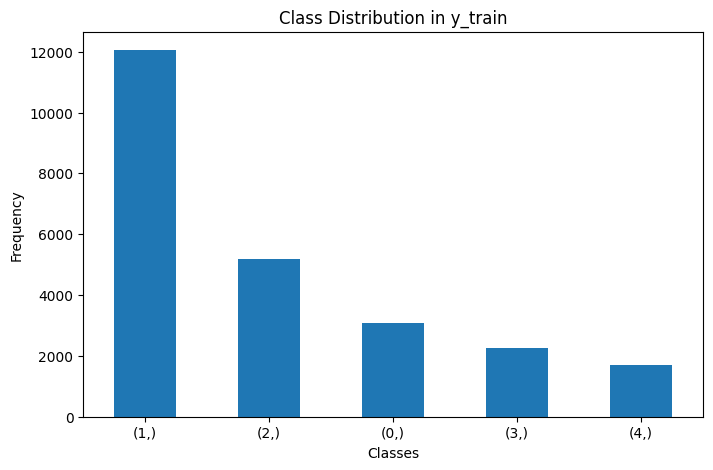

In [55]:
# Plotting the class distribution
plt.figure(figsize=(8, 5))
class_distribution.plot(kind='bar')
plt.title('Class Distribution in y_train')
plt.xlabel('Classes')
plt.ylabel('Frequency')
plt.xticks(rotation=0)
plt.show()

In [56]:
# from imblearn.over_sampling import SMOTE

# smote = SMOTE()
# x_resampled, y_resampled = smote.fit_resample(df, y)
# x_resampled

,ID,GameFormat,SR,BattingInnings,IsOut,Opposition,Ground,TossResult,MatchTime,isTossWon,...,Opps,MaxTemp,MinTemp,MaxWind,Tournament,BattingOrder,Role,Country,Batting Hand,Age
0,2,6,0.000000,2,1,235,91,0,2,0,...,1.092700,25.300000,13.600000,15.900000,1,2,3,5,1,25
1,2,3,0.000000,2,1,235,91,0,2,0,...,1.092700,25.300000,13.600000,15.900000,1,2,3,5,1,25
2,5,6,0.000000,2,1,66,36,0,0,0,...,1.092700,32.600000,16.500000,24.500000,6,1,1,8,1,23
3,5,6,173.684211,1,1,281,75,0,2,1,...,1.092700,25.500000,20.300000,28.600000,6,1,1,8,1,23
4,5,6,150.000000,2,1,40,33,0,2,0,...,1.092700,27.900000,17.300000,26.700000,6,1,1,8,1,23
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60265,70,6,117.046781,2,0,252,84,0,1,0,...,2.074163,20.916964,14.328385,12.172268,11,1,3,3,0,22
60266,17,3,144.737422,1,1,11,144,1,1,0,...,4.496598,19.400000,8.900000,20.500000,1,1,3,3,1,32
60267,17,6,144.327978,1,1,33,173,1,2,0,...,2.390284,21.689916,12.770151,18.864336,10,1,3,3,1,32
60268,149,6,146.994571,1,1,222,85,0,1,0,...,2.897571,36.657251,24.706746,14.411853,4,1,1,6,0,23


In [57]:
x_train, x_test, y_train, y_test = train_test_split(df, y, test_size=0.1, random_state=42)

In [58]:
x_validation, x_test, y_validation, y_test = train_test_split(x_test, y_test, test_size=0.5, random_state=42)

In [ ]:
def focal_loss(gamma=2.0, alpha=0.25):
    def focal_loss_fixed(y_true, y_pred):
        epsilon = K.epsilon()
        y_pred = K.clip(y_pred, epsilon, 1. - epsilon)
        cross_entropy = -y_true * K.log(y_pred)
        loss = alpha * K.pow(1 - y_pred, gamma) * cross_entropy
        return K.sum(loss, axis=1)
    return focal_loss_fixed

In [20]:
import sklearn
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import time
import joblib
from sklearn.model_selection import GridSearchCV
from imblearn.over_sampling import SMOTE
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV

In [ ]:
accuracyEta = []
Eta = []
plt.ion()
fig, ax = plt.subplots()
line, = ax.plot([], [], 'bo-')
for eta in range(100, 600, 200):
  clf = xgb.XGBClassifier(
        n_estimators=eta, max_depth=15, learning_rate=0.1,
        eval_metric="logloss", colsample_bytree=0.8, subsample=0.8,
        tree_method='hist',
        device='cuda',
        objective='multi:softmax',
        enable_categorical=True
  )
  clf.fit(x_train, y_train)
  y_pred = clf.predict(x_validation)
  accuracyEta.append(accuracy_score(y_validation, y_pred))
  Eta.append(eta)
  line.set_xdata(Eta)
  line.set_ydata(accuracyEta)

  ax.relim()  # Recalculate limits
  ax.autoscale_view()  # Rescale the view

  plt.draw()
  plt.pause(0.1)  # Pause to update the figure
  time.sleep(0.1)
  plt.plot(Eta, accuracyEta)

In [ ]:
accuracyDepth = []
Depth = []
plt.ion()
fig, ax = plt.subplots()
line, = ax.plot([], [], 'bo-')
for depth in range(6, 25, 4):
  clf = xgb.XGBClassifier(
        n_estimators=500, max_depth=depth, learning_rate=0.1,
        eval_metric="logloss", colsample_bytree=0.8, subsample=0.8,
        tree_method='hist',
        device='cuda',
        objective='multi:softmax',
        enable_categorical=True
    )
  clf.fit(x_train, y_train)
  y_pred = clf.predict(x_validation)
  accuracyDepth.append(accuracy_score(y_validation, y_pred))
  Depth.append(depth)
  line.set_xdata(Depth)
  line.set_ydata(accuracyDepth)

  ax.relim()  # Recalculate limits
  ax.autoscale_view()  # Rescale the view

  plt.draw()
  plt.pause(0.1)  # Pause to update the figure
  time.sleep(0.1)
  plt.plot(Depth, accuracyDepth)

In [ ]:
# clf = xgb.XGBClassifier(
#         n_estimators=eta, max_depth=10, learning_rate=0.1,
#         eval_metric="logloss", colsample_bytree=0.8, subsample=0.8,
#         tree_method='hist',
#         device='cuda',
#         objective='multi:softmax',
#         enable_categorical=True
#   )
# clf.fit(x_train, y_train)

clf = xgb.XGBClassifier(
       n_estimators=eta, 
       max_depth=10, 
       learning_rate=0.1,
       eval_metric="logloss", 
       colsample_bytree=0.8, 
       subsample=0.8,
       tree_method='hist',
       device='cuda',
       objective='multi:softmax',
       enable_categorical=True,
       reg_alpha=1,  # L1 regularization
       reg_lambda=1  # L2 regularization
       )

In [ ]:
evals = [(x_train, y_train), (x_validation, y_validation)]
clf.fit(x_train, y_train, eval_set=evals)

In [ ]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(clf, x_train, y_train, cv=5)  # 5-fold cross-validation
print(f'Cross-Validation Accuracy: {scores.mean():.4f} ± {scores.std():.4f}')

In [ ]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [5, 10, 15],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0]
    }

grid_search = GridSearchCV(estimator=clf, param_grid=param_grid, scoring='accuracy', cv=3)
grid_search.fit(x_train, y_train)
print(f'Best Parameters: {grid_search.best_params_}')

In [ ]:
# Calculate training accuracy
train_accuracy = clf.score(x_train, y_train)

# Print the training accuracy
print(f'Training Accuracy: {train_accuracy:.4f}')

# Calculate validation accuracy
val_accuracy = clf.score(x_validation, y_validation)

# Print the validation accuracy
print(f'Validation Accuracy: {val_accuracy:.4f}')

In [24]:
y_pred = clf.predict(x_test)
accuracy = accuracy_score(y_test, y_pred)

In [ ]:
print(accuracy)

In [ ]:
import xgboost as xgb
from sklearn.metrics import accuracy_score

# Initialize the classifier
clf = xgb.XGBClassifier(
    n_estimators=1000,  # Set a high number of estimators
    max_depth=10, 
    learning_rate=0.1,
    eval_metric="logloss", 
    colsample_bytree=0.8, 
    subsample=0.8,
    tree_method='hist',
    device='cuda',
    objective='multi:softmax',
    enable_categorical=True
)

# Fit the model without early stopping
clf.fit(x_train, y_train)

In [ ]:
# Monitor validation accuracy
best_val_accuracy = 0
patience = 10  # Number of rounds to wait for improvement
stopping_rounds = 0

for i in range(25, 50):  # Loop through a high number of iterations
    clf.n_estimators = i + 1  # Increment the number of estimators
    clf.fit(x_train, y_train)  # Fit the model
    train_accuracy = clf.score(x_train, y_train)
    val_accuracy = clf.score(x_validation, y_validation)  # Calculate validation accuracy
    print(f"{i}: Training Accuracy= {train_accuracy} Validation Accuracy= {val_accuracy}, Best Accuracy= {best_val_accuracy}")
    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        stopping_rounds = 0  # Reset patience counter
    else:
        stopping_rounds += 1

    if stopping_rounds >= patience:
        print(f"Early stopping at iteration {i + 1}")
        break

# Final training and validation accuracy
train_accuracy = clf.score(x_train, y_train)
print(f'Training Accuracy: {train_accuracy:.4f}')
print(f'Best Validation Accuracy: {best_val_accuracy:.4f}')